# Identifying the outliers using spectral clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from scipy.spatial.distance import pdist, squareform
except ImportError:
    %pip install scikit-learn scipy
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from scipy.spatial.distance import pdist, squareform

## DataSet Description

In [2]:
df = pd.read_csv('data/data.csv')
n, d = df.shape
print('n =', n, 'd =', d)
df.describe()

n = 1199 d = 10


cov1         cov2         cov3         cov4         cov5  \
count  1199.000000  1199.000000  1199.000000  1199.000000  1199.000000   
mean      0.956896     0.855770     0.214263     0.147359     0.036329   
std       0.135031     0.244927     0.408193     0.388080     0.177615   
min      -0.312219    -0.531958    -0.818128    -0.839158    -0.719622   
25%       0.982505     0.840675    -0.095193    -0.143054     0.000000   
50%       0.999235     0.969806     0.175910     0.097584     0.000000   
75%       0.999993     0.996604     0.563061     0.457633     0.000000   
max       1.000000     1.000000     1.000000     0.979015     0.999196   

              cov6         cov7   sal_pur_rat  igst_itc_tot_itc_rat  \
count  1199.000000  1199.000000  1.199000e+03          1.199000e+03   
mean      0.599809     0.527768 -1.251042e-11         -5.004165e-12   
std       0.334306     0.385322  1.000000e+00          1.000000e+00   
min      -0.682734    -0.859529 -3.531330e-02         -1.066436e+00   
25%       0.382479     0.245701 -3.284146e-02         -8.884636e-01   
50%       0.691423     0.595623 -3.254101e-02         -3.457085e-01   
75%       0.873218     0.869592 -3.194269e-02          7.059485e-01   
max       0.999999     1.000000  3.436719e+01          2.177948e+00   

       lib_igst_itc_rat  
count      1.199000e+03  
mean       1.918265e-11  
std        1.000000e+00  
min       -5.444774e-02  
25%       -5.424427e-02  
50%       -5.382146e-02  
75%       -5.191380e-02  
max        3.318828e+01

In [3]:
%%bash
mkdir -p images

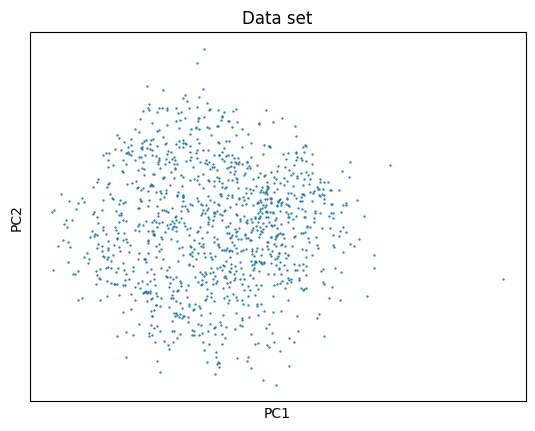

In [4]:
df = StandardScaler().fit_transform(df)
visibility = 0.06
line_width = 0.1


pca = PCA(n_components=2)
pc = pca.fit_transform(StandardScaler().fit_transform(df))

# plt.figure(figsize=(5, 5))
plt.scatter(pc[:, 0], pc[:, 1], s=0.4)
plt.xticks([])
plt.yticks([])
plt.title('Data set')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('images/dataSet.png')
plt.show()


## Similarity matrix

### $\epsilon$-neighborhood

In [26]:
def get_alphaNeighborhoodGraph(alpha, df, dist='euclidean'):
    """Compute the alpha-neighborhood graph of the data points in df.
    @param dist: distance metric to use (default: euclidean) `'euclidean' | 'cosine'`
    return A, L where A is the adjacency matrix and L is the Laplacian matrix.
    """
    assert dist in ['euclidean', 'cosine'], 'dist must be either `euclidean` or `cosine`'

    n = df.shape[0]
    A = np.zeros((n, n))
    distances = squareform(pdist(df, metric=dist))
    # print(distances.shape, distances.min(), distances.max(), distances.mean())  
    for i in range(n):
        for j in range(i + 1, n):
            if distances[i, j] <= alpha:
                A[i, j] = 1
                A[j, i] = 1

    D = np.diag(np.sum(A, axis=1))
    L = D - A
    return A, L


#### Tuning $\epsilon$ for the $\epsilon$-neighborhood

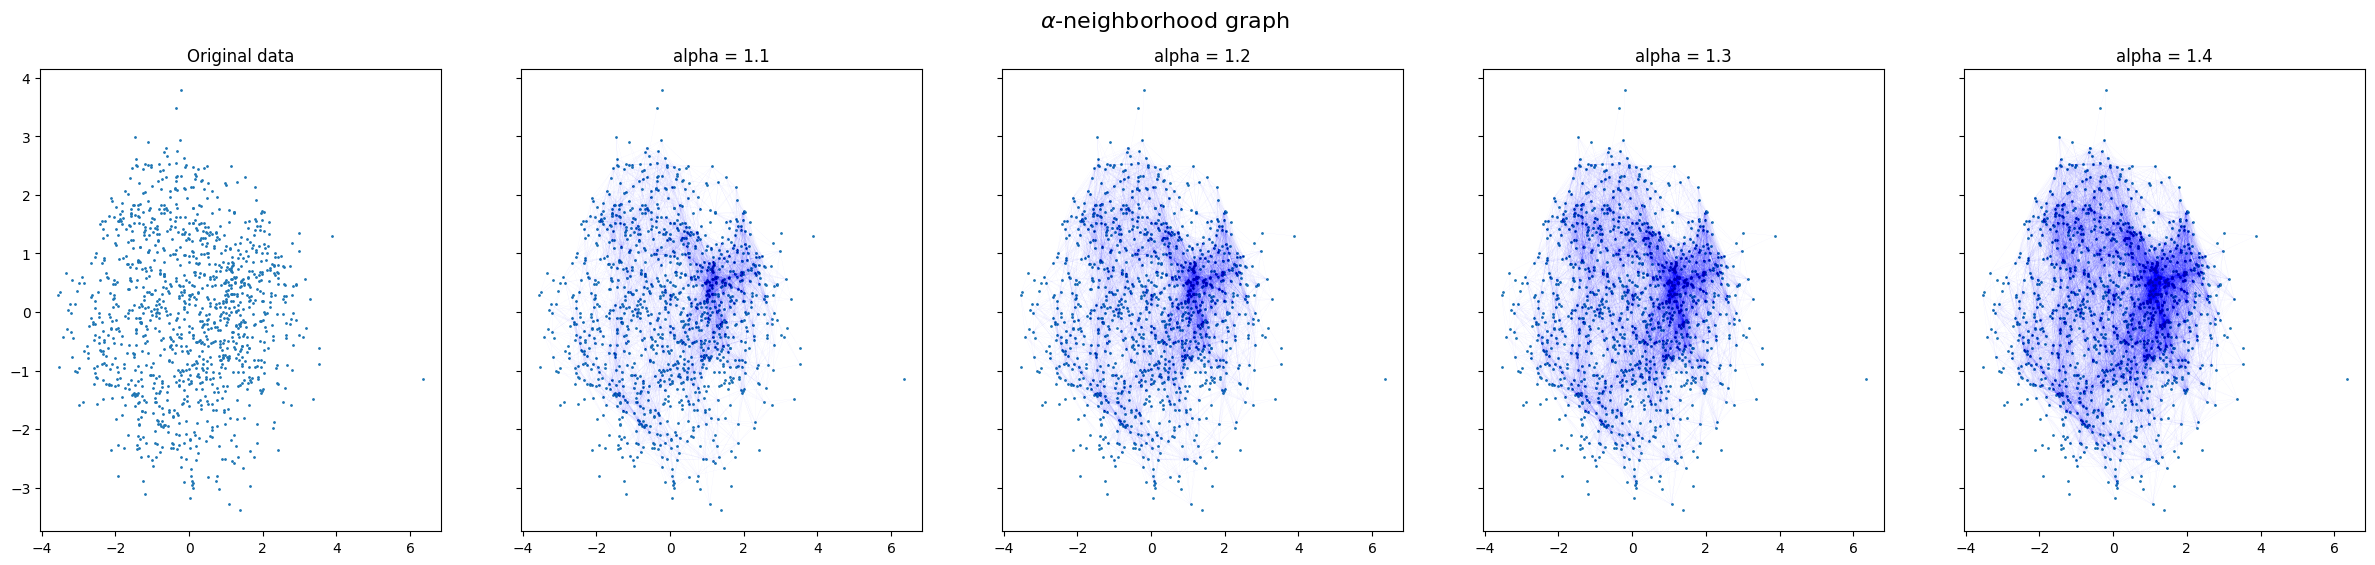

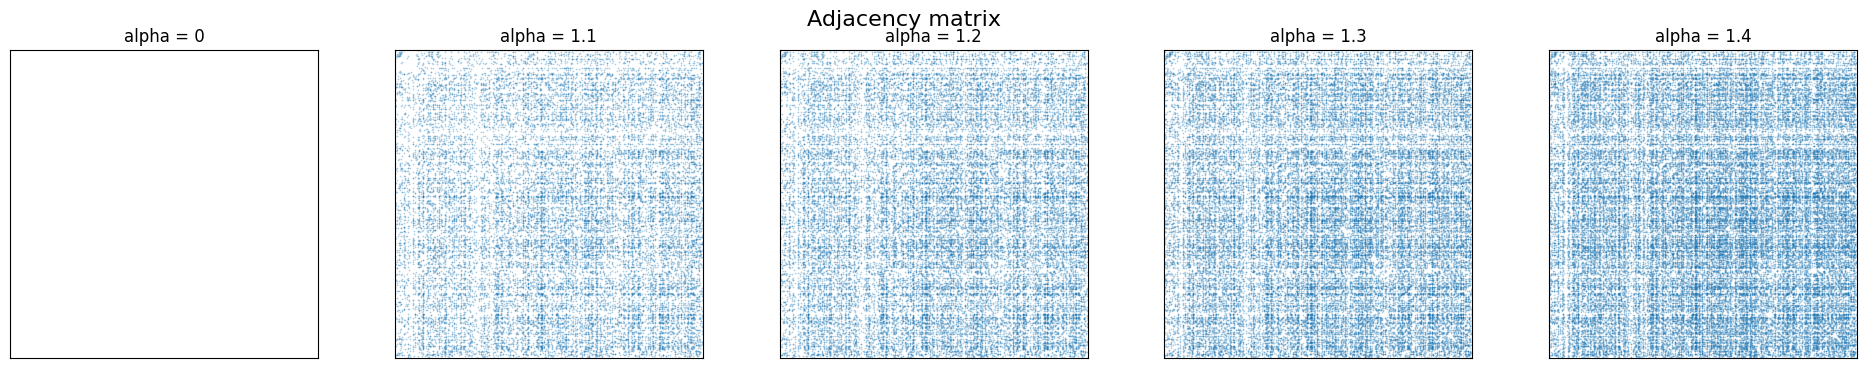

In [27]:
fig, ax = plt.subplots(1, 5, figsize=(30, 6), sharey=True, sharex=True)
ax[0].scatter(pc[:, 0], pc[:, 1], s=1)
ax[0].set_title('Original data')


# Parameter tuning for alpha
alphas = [1.1,  1.2, 1.3, 1.4]
for i, alpha in enumerate(alphas):
    A, L = get_alphaNeighborhoodGraph(alpha, df)
    ax[i + 1].scatter(pc[:, 0], pc[:, 1], s=1)
    ax[i + 1].set_title('alpha = {}'.format(alpha))
    for ind1, ind2 in zip(*np.where(A == 1)):
        ax[i + 1].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1], lw=line_width, c='b', alpha=visibility)

fig.suptitle(r'$\alpha$-neighborhood graph', fontsize=16)
plt.savefig('images/alpha_neighborhood_graph.png')
plt.show()


# Plot the sparcity of the Adjancy Matrix
fig, ax = plt.subplots(1, 5, figsize=(24, 4), sharey=True, sharex=True)
for i, alpha in enumerate([0]+alphas):
    A, L = get_alphaNeighborhoodGraph(alpha, df)
    ax[i].spy(A, markersize=0.1)
    ax[i].set_title('alpha = {}'.format(alpha))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.suptitle('Adjacency matrix', fontsize=16)
plt.savefig('images/adjacency_matrix_alpha_neighborhood_graph.png')
plt.show()


alpha1 = 1.3         # Best alpha TODO: set to the best alpha

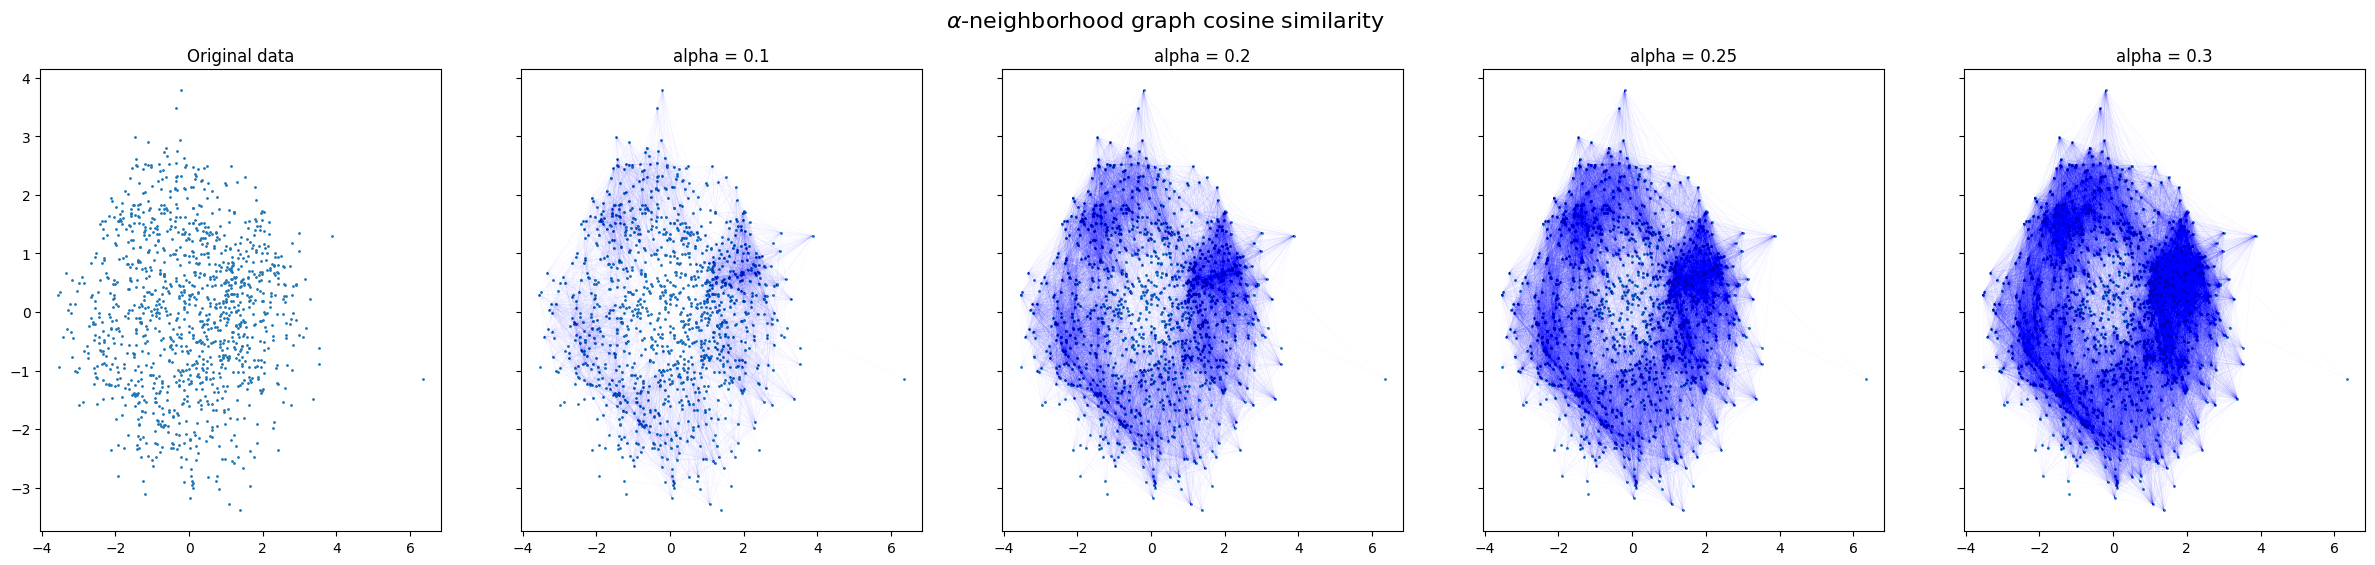

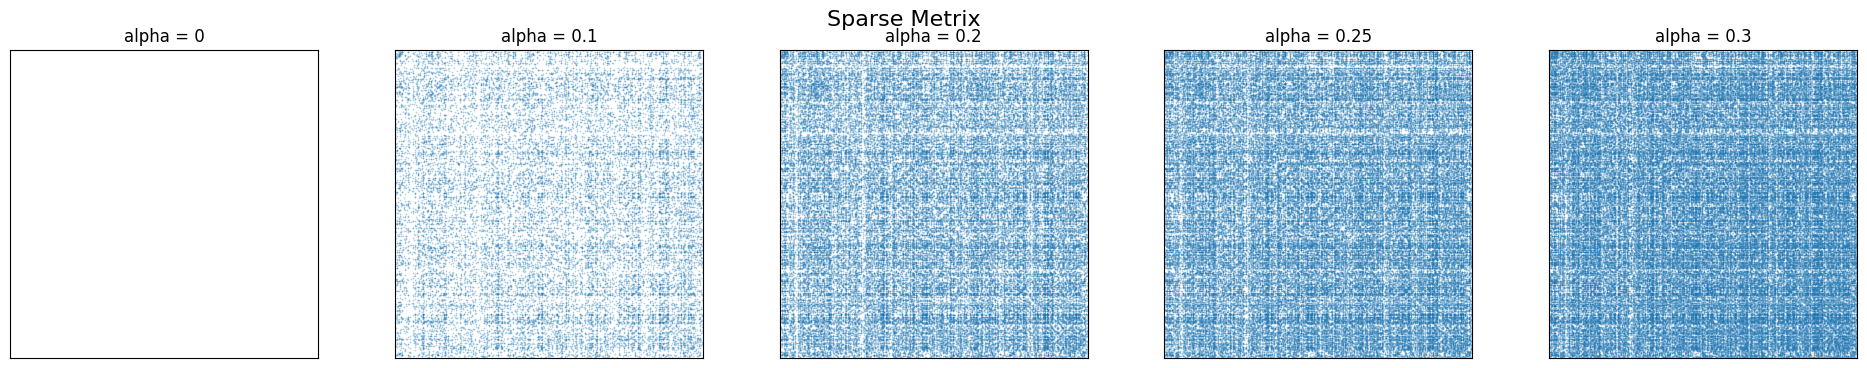

In [28]:
fig, ax = plt.subplots(1, 5, figsize=(30, 6), sharey=True, sharex=True)
ax[0].scatter(pc[:, 0], pc[:, 1], s=1)
ax[0].set_title('Original data')

# Parameter tuning for alpha
alphas = [0.1, 0.2, 0.25, 0.3 ]
for i, alpha in enumerate(alphas):
    A, L = get_alphaNeighborhoodGraph(alpha, df, dist='cosine')
    ax[i + 1].scatter(pc[:, 0], pc[:, 1], s=1)
    ax[i + 1].set_title('alpha = {}'.format(alpha))
    for ind1, ind2 in zip(*np.where(A == 1)):
        ax[i + 1].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1], lw=line_width, c='b', alpha=visibility)

fig.suptitle(r'$\alpha$-neighborhood graph cosine similarity', fontsize=16)
plt.savefig('images/alpha_neighborhood_graph_cosine_similarity.png')
plt.show()

# Plot the sparcity of the Adjancy Matrix
fig, ax = plt.subplots(1, 5, figsize=(24, 4), sharey=True, sharex=True)
for i, alpha in enumerate([0]+alphas):
    A, L = get_alphaNeighborhoodGraph(alpha, df, dist='cosine')
    ax[i].spy(A, markersize=0.1)
    ax[i].set_title('alpha = {}'.format(alpha))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.suptitle('Sparse Metrix', fontsize=16)
plt.savefig('images/adjacency_matrix_alpha_neighborhood_cosine_similarity_graph.png')
plt.show()

alpha2 = 0.2         # Best alpha TODO: set to the best alpha


In [6]:
alpha1 = 1.3
alpha2 = 0.2

### k-nearest neighbor

In [29]:
def get_kNNGraph(k, df, mutual=False, dist='euclidean'):
    """
    Compute the k-nearest neighbor graph of the data points in df.
    If mutual is True, only keep edges that are mutual. (i.e. (i,j) is an edge iff i is among the k-nearest neighbors of j and j is among the k-nearest neighbors of i)
    return A, L where A is the adjacency matrix and L is the Laplacian matrix.
    """
    n = df.shape[0]
    A = np.zeros((n, n))
    distances = pdist(df, dist)
    distances = squareform(distances)
    distances = np.where(distances == 0, np.inf, distances)

    neighbors = np.argsort(distances)[:, :k]
    for i in range(n):
        if mutual:
            if i not in neighbors[neighbors[i]]:
                continue
        A[i, neighbors[i]] = A[neighbors[i], i] = distances[i, neighbors[i]]

    D = np.diag(np.sum(A, axis=1))
    L = D - A
    return A, L


#### Tuning $k$ for the k-nearest neighbor

##### Simple k-nearest neighbor

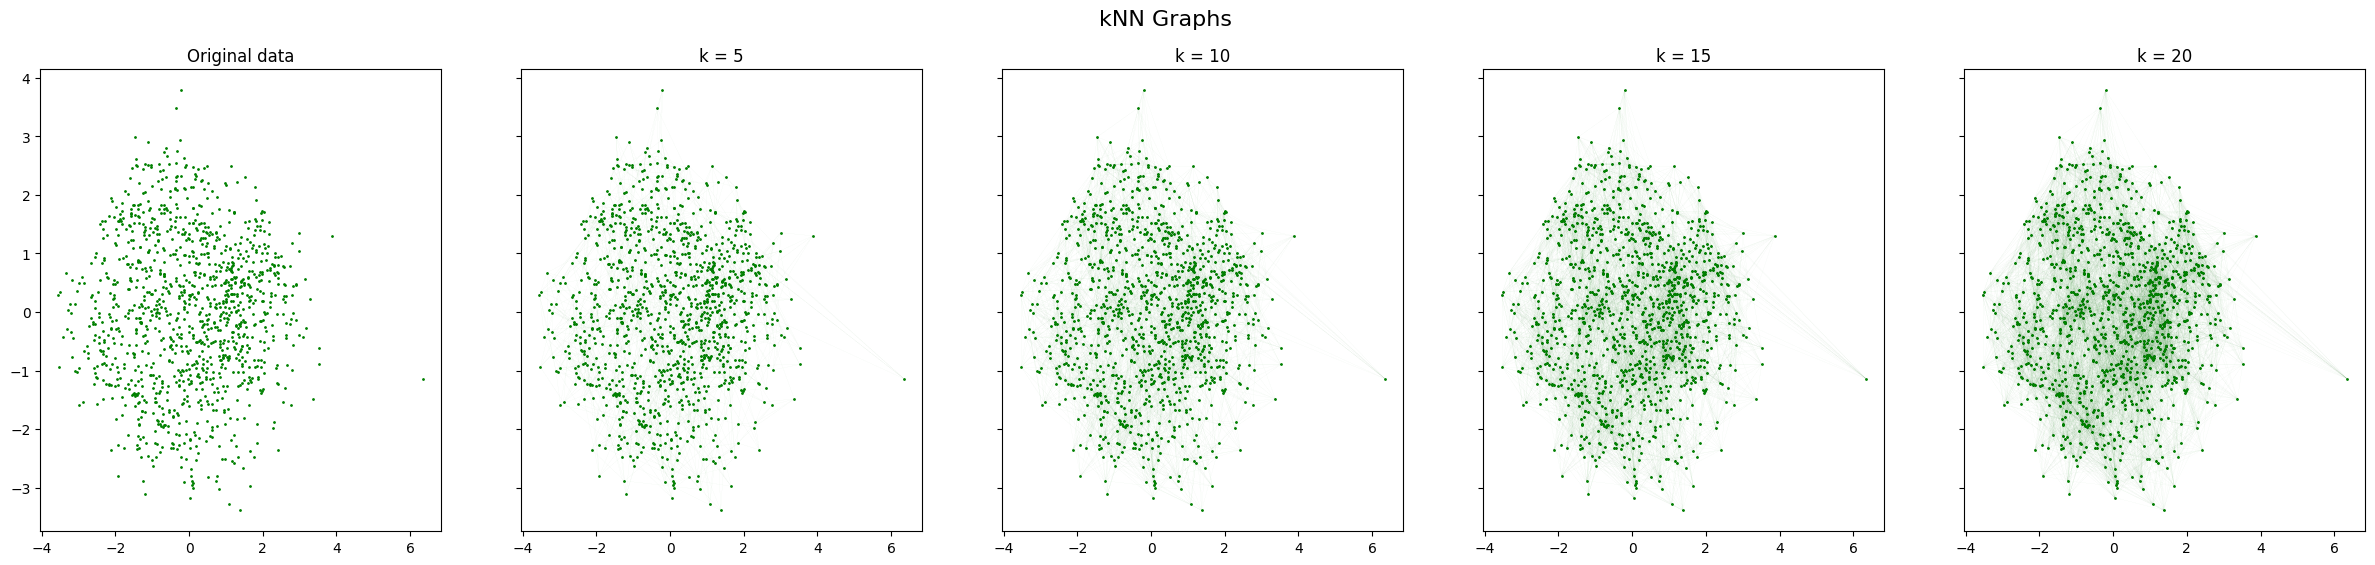

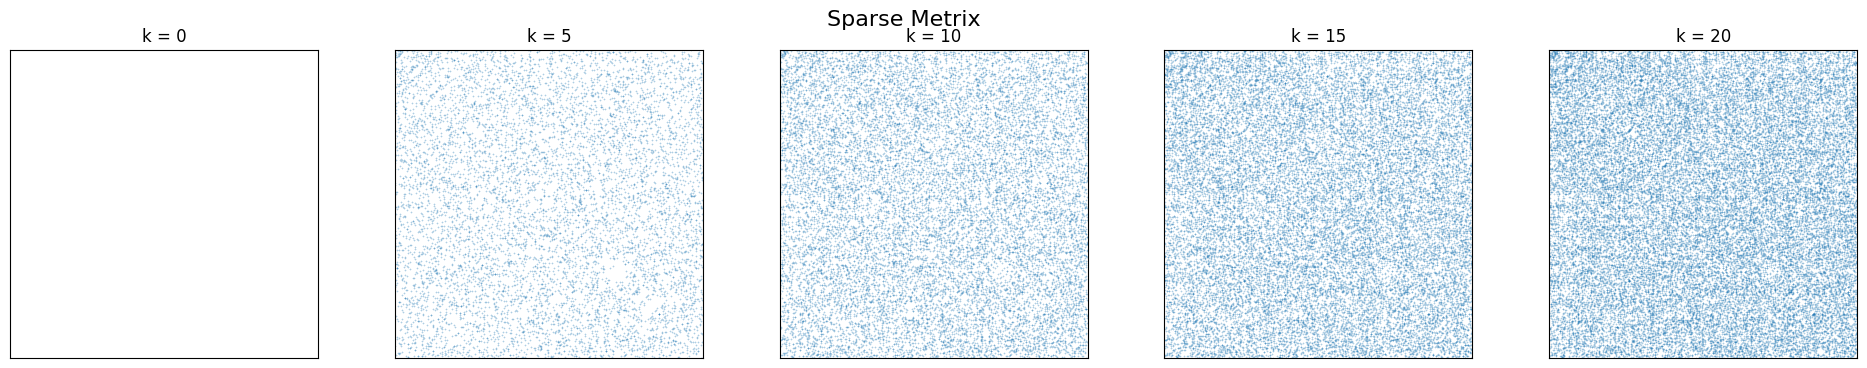

In [30]:
fig, ax = plt.subplots(1, 5, figsize=(30, 6), sharey=True, sharex=True)
ax[0].scatter(pc[:, 0], pc[:, 1], s=1, c='g')
ax[0].set_title('Original data')

# Parameter tuning for k
ks = [5, 10, 15, 20]
for i, k in enumerate(ks):
    A, L = get_kNNGraph(k, df, mutual=False)
    ax[i + 1].scatter(pc[:, 0], pc[:, 1], s=1, c='g')
    ax[i + 1].set_title('k = {}'.format(k))
    for ind1, ind2 in zip(*np.where(A != 0)):
        ax[i + 1].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1],
                       lw=line_width, c='g', alpha=visibility)

k1 = 20        # Best k1 TODO: set to the best k1
fig.suptitle('kNN Graphs', fontsize=16)
plt.savefig('images/knn_graphs.png')
plt.show()

# Plot the sparcity of the Adjancy Matrix
fig, ax = plt.subplots(1, 5, figsize=(24, 4), sharey=True, sharex=True)
for i, k in enumerate([0]+ks):
    A, L = get_kNNGraph(k, df)
    ax[i].spy(A, markersize=0.1)
    ax[i].set_title('k = {}'.format(k))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.suptitle('Sparse Metrix', fontsize=16)
plt.savefig('images/adjacency_matrix_knn_graph.png')
plt.show()  


##### mutual k-nearest neighbor

With mutual = True


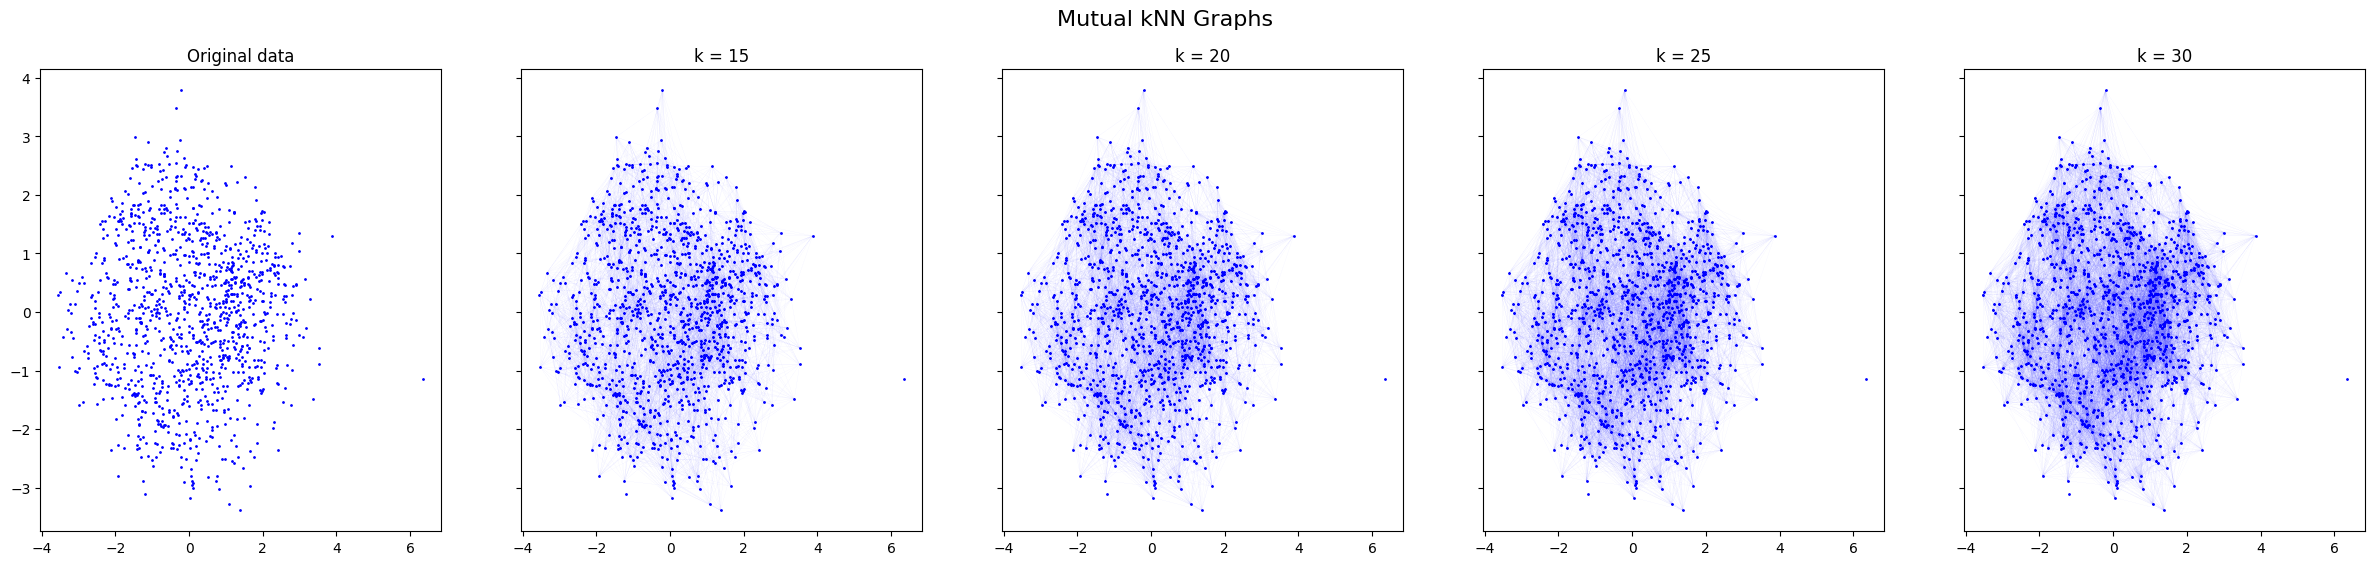

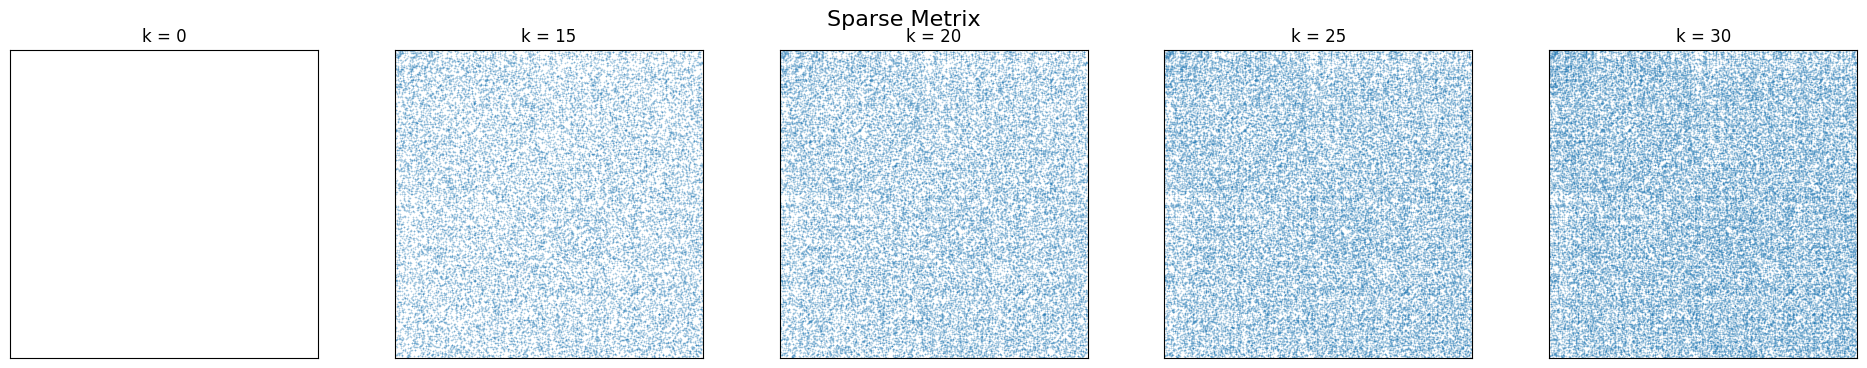

In [31]:

print("With mutual = True")
fig, ax = plt.subplots(1, 5, figsize=(30, 6), sharey=True, sharex=True)
ax[0].scatter(pc[:, 0], pc[:, 1], s=1, c='b')
ax[0].set_title('Original data')

# Parameter tuning for k
ks = [15, 20, 25, 30]
for i, k in enumerate(ks):
    A, L = get_kNNGraph(k, df, mutual=True)
    ax[i + 1].scatter(pc[:, 0], pc[:, 1], s=1, c='b')
    ax[i + 1].set_title('k = {}'.format(k))
    for ind1, ind2 in zip(*np.where(A != 0)):
        ax[i + 1].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1],
                       lw=line_width, c='b', alpha=visibility)

k2 = 15        # Best k2 TODO: set to the best k2

# Set the global title of the figure
fig.suptitle('Mutual kNN Graphs', fontsize=16)
plt.savefig('images/mutual_knn_graphs.png')
plt.show()

# Plot the sparcity of the Adjancy Matrix
fig, ax = plt.subplots(1, 5, figsize=(24, 4), sharey=True, sharex=True)
for i, k in enumerate([0]+ks):
    A, L = get_kNNGraph(k, df, mutual=True)
    ax[i].spy(A, markersize=0.1)
    ax[i].set_title('k = {}'.format(k))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.suptitle('Sparse Metrix', fontsize=16)
plt.savefig('images/adjacency_matrix_mutual_knn_graph.png')
plt.show()


In [8]:
k1 = 20
k2 = 25

### Fullly connected graph

In [9]:
def get_fullyConnectedGraph(df, sigma=1):
    """
    Compute the fully connected graph of the data points in df.
    return A, L where A is the adjacency matrix and L is the Laplacian matrix.
    """
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            A[i, j] = np.exp(-np.linalg.norm(df[i] - df[j]) ** 2 / (2 * sigma ** 2))
            A[j, i] = A[i, j]

    D = np.diag(np.sum(A, axis=1))
    L = D - A
    return A, L


### Plotting the similarity matrix for the different similarity measures

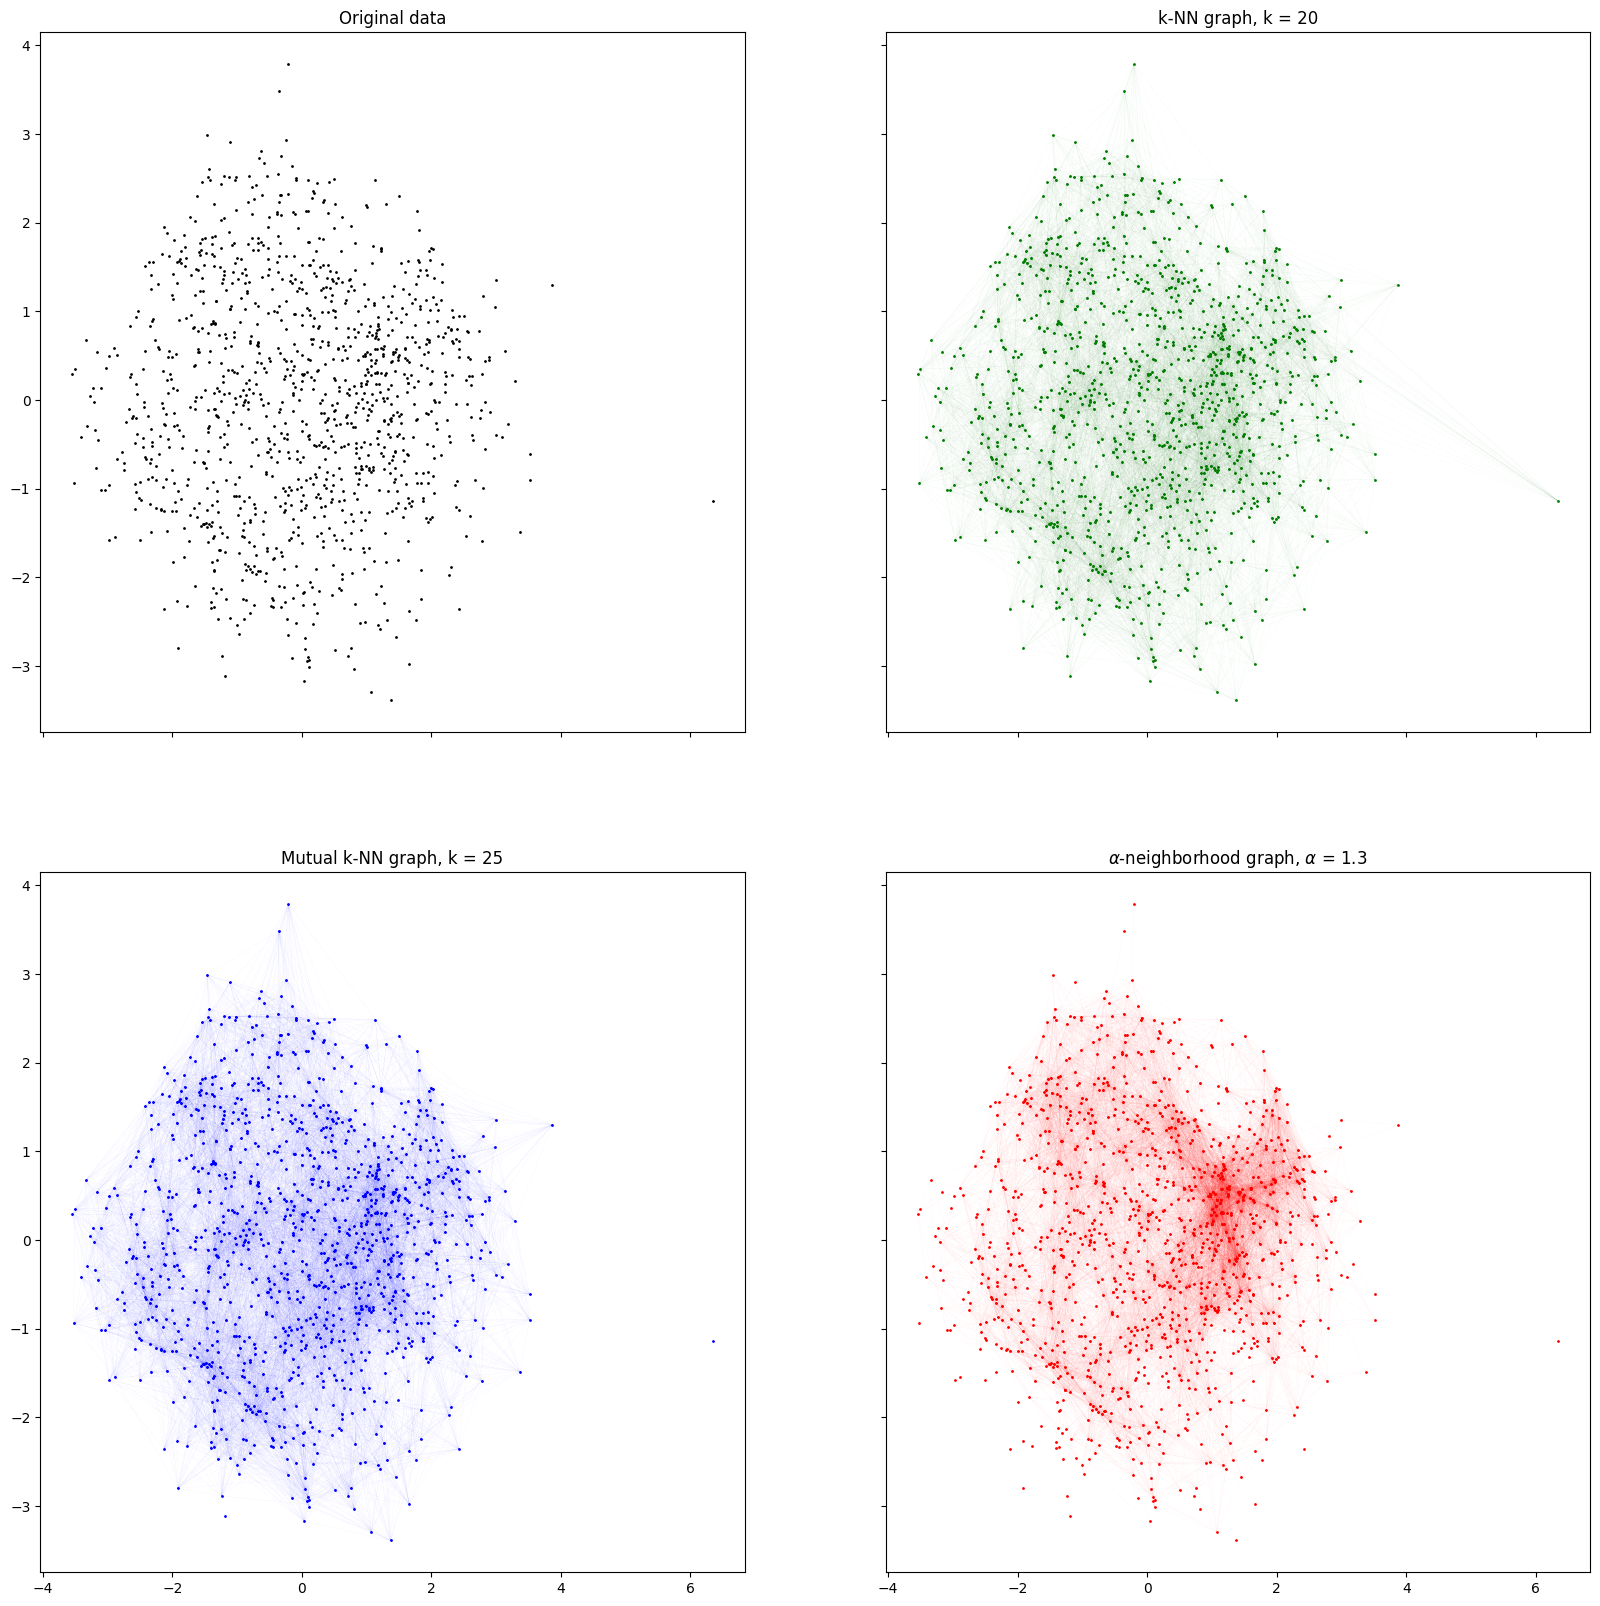

In [27]:
# Plot all the graphs with best parameters
fig, ax = plt.subplots(2, 2, figsize=(20, 20), sharey=True, sharex=True)
ax[0, 0].scatter(pc[:, 0], pc[:, 1], s=1, c='k')
ax[0, 0].set_title('Original data')

A, L = get_alphaNeighborhoodGraph(alpha1, df)
ax[1, 1].scatter(pc[:, 0], pc[:, 1], s=1, c='r')
ax[1, 1].set_title(r'$\alpha$-neighborhood graph, $\alpha$ = {}'.format(alpha1))
for ind1, ind2 in zip(*np.where(A == 1)):
    ax[1, 1].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1], lw=line_width, c='r', alpha=visibility)

A, L = get_kNNGraph(k1, df, mutual=False)
ax[0, 1].scatter(pc[:, 0], pc[:, 1], s=1, c='g')
ax[0, 1].set_title('k-NN graph, k = {}'.format(k1))
for ind1, ind2 in zip(*np.where(A != 0)):
    ax[0, 1].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1], lw=line_width, c='g', alpha=visibility)

A, L = get_kNNGraph(k2, df, mutual=True)
ax[1, 0].scatter(pc[:, 0], pc[:, 1], s=1, c='b')
ax[1, 0].set_title('Mutual k-NN graph, k = {}'.format(k2))
for ind1, ind2 in zip(*np.where(A != 0)):
    ax[1, 0].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1], lw=line_width, c='b', alpha=visibility)

plt.savefig('images/all_graphs_with_best_parameters.png')
plt.show()

## Normalizing the Laplacian matrix

In [14]:
def normalizeLaplacian(L, norm='sym'):
    """Compute the normalized Laplacian matrix of L.
    @param norm: type of normalization to use (default: symmetric normalization) `'sym' | 'rw'`
    return: normalized Laplacian matrix
    """
    assert norm in ['sym', 'rw'], 'norm must be either `sym` or `rw`'

    if norm == 'sym':
        D = np.diag(np.diag(L)) + np.diag(1e-8 * np.ones(L.shape[0]))
        D_sqrt = np.sqrt(np.linalg.inv(D))
        L_norm = D_sqrt @ L @ D_sqrt
    else:
        D = np.diag(np.diag(L)) + np.diag(1e-8 * np.ones(L.shape[0]))
        L_norm = np.linalg.inv(D) @ L

    return L_norm


# Testing above functions
# L = np.array([[2, -1, -1], [-1,  2, -1], [-1, -1,  2]])
# L_norm = normalizeLaplacian(L, norm='sym')
# print('L_norm(sym) =\n', L_norm)
# L_norm = normalizeLaplacian(L, norm='rw')
# print('L_norm(rw) =\n', L_norm)


## Eigen decomposition 

In [11]:
def get_eigenvectors(L, k=-1):
    """Compute the k smallest eigenvalues and eigenvectors of L.
    return: eigenvalues, eigenvectors
    """
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues[2:k+1], eigenvectors[:,2:k+1] # TODO: change 2 to 1

def eigenGap(eigenvalues, k):
    """Compute the eigen gap of the eigenvalues.
    return: eigen gap
    """
    return eigenvalues[k] - eigenvalues[k - 1]

def get_bestK(eigenvalues, max_k=10):
    """Compute the best k for the k-means algorithm.
    return: best k
    """
    eigenGap_values = [eigenGap(eigenvalues, k) for k in range(2, max_k)]
    return np.argmax(eigenGap_values) + 2

### Unnormalize Laplacian

In [10]:
A_alpha, L_alpha = get_alphaNeighborhoodGraph(alpha2, df, dist='cosine')
A_kNN, L_kNN = get_kNNGraph(k1, df, mutual=False)
A_mutual, L_mutual = get_kNNGraph(k2, df, mutual=True)
# A_full, L_full = A_mutual, L_mutual
A_full, L_full = get_fullyConnectedGraph(df)
As = [A_alpha, A_kNN, A_mutual, A_full]
Ls = [L_alpha, L_kNN, L_mutual, L_full]


Best k for alpha-neighborhood graph: 4
Best k for k-NN graph: 6
Best k for Mutual k-NN graph: 2
Best k for Fully connected graph: 9


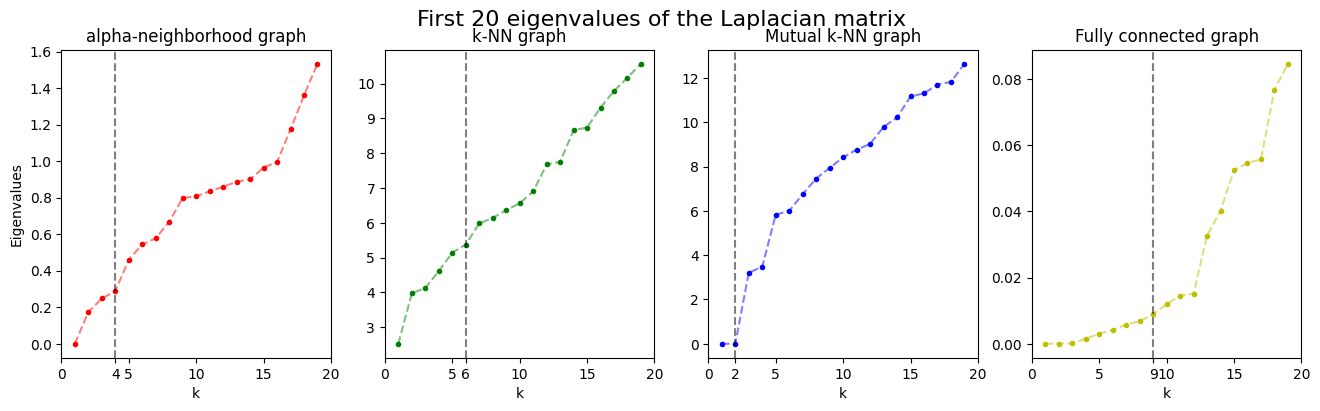

In [19]:
plots_titles = ['alpha-neighborhood graph', 'k-NN graph', 'Mutual k-NN graph', 'Fully connected graph']
C = ['r', 'g', 'b', 'y', 'm']
k = 20
x_values = np.arange(1, k)
best_Ks = []
eigenvectors_list = []

# Plotting the graphs
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    eigenvalues, eigenvectors = get_eigenvectors(Ls[i], k=k)
    eigenvectors_list.append(eigenvectors)
    best_k = get_bestK(eigenvalues)
    best_Ks.append(best_k)
    print('Best k for {}: {}'.format(plots_titles[i], best_k))
    ax[i].plot(x_values, eigenvalues, '.', c=C[i])
    ax[i].plot(x_values, eigenvalues, '--', c=C[i], alpha=0.5)
    ax[i].axvline(best_k, c='k', ls='--', alpha=0.5)
    ax[i].set_title(plots_titles[i])
    ax[i].set_xticks(np.append(ax[i].get_xticks(), best_k))
    ax[i].set_xlabel('k')
ax[0].set_ylabel('Eigenvalues')
fig.suptitle(f'First {k} eigenvalues of the Laplacian matrix', fontsize=16)
plt.savefig('images/eigenvalues.png')
plt.show()

    

### Normalized Laplacian

In [15]:
L_norm_alpha = normalizeLaplacian(L_alpha, norm='sym')
L_norm_kNN = normalizeLaplacian(L_kNN, norm='sym')
L_norm_mutual = normalizeLaplacian(L_mutual, norm='sym')
L_norm_full = normalizeLaplacian(L_full, norm='sym')
L_norms = [L_norm_alpha, L_norm_kNN, L_norm_mutual, L_norm_full]


Best k for alpha-neighborhood graph: 8
Best k for k-NN graph: 6
Best k for Mutual k-NN graph: 2
Best k for Fully connected graph: 7


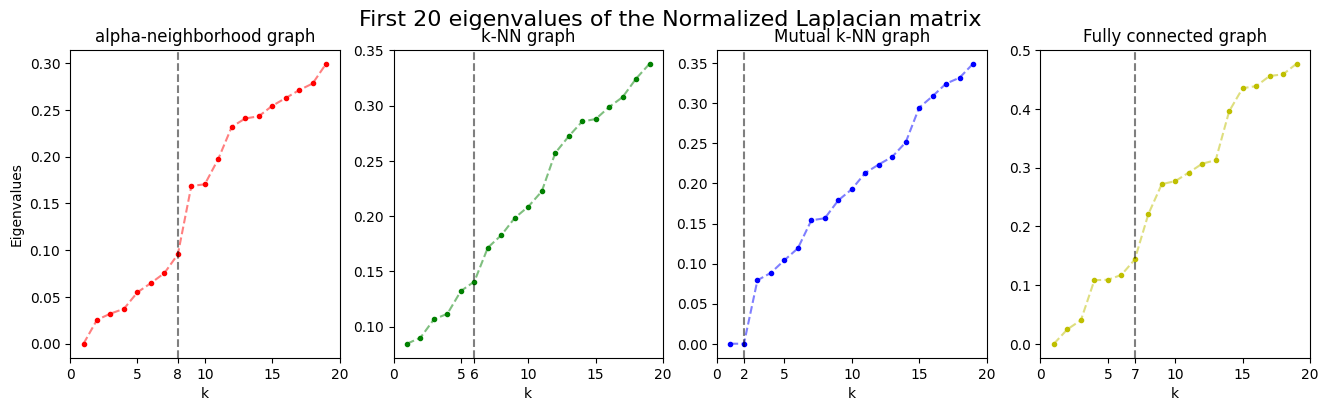

In [16]:
plots_titles = ['alpha-neighborhood graph', 'k-NN graph',
                'Mutual k-NN graph', 'Fully connected graph']
C = ['r', 'g', 'b', 'y', 'm']
k = 20
x_values = np.arange(1, k)
norm_best_Ks = []
norm_eigenvectors_list = []

# Plotting the graphs
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    eigenvalues, eigenvectors = get_eigenvectors(L_norms[i], k=k)
    norm_eigenvectors_list.append(eigenvectors)
    norm_best_k = get_bestK(eigenvalues)
    norm_best_Ks.append(norm_best_k)
    print('Best k for {}: {}'.format(plots_titles[i], norm_best_k))
    ax[i].plot(x_values, eigenvalues, '.', c=C[i])
    ax[i].plot(x_values, eigenvalues, '--', c=C[i], alpha=0.5)
    ax[i].axvline(norm_best_k, c='k', ls='--', alpha=0.5)
    ax[i].set_title(plots_titles[i])
    ax[i].set_xticks(np.append(ax[i].get_xticks(), norm_best_k))
    ax[i].set_xlabel('k')
ax[0].set_ylabel('Eigenvalues')
fig.suptitle(f'First {k} eigenvalues of the Normalized Laplacian matrix', fontsize=16)
plt.savefig('images/eigenvalues_normalized.png')
plt.show()


## Clustering Algorithms

### cluster multiple eigenvectors   
- build a reduce space from multiple eigenvectors [shi & Malik, 2000]
- https://stats.stackexchange.com/questions/96539/motivations-for-shi-malik-algorithm

<!-- ![image.png](attachment:image.png) -->


#### Unnormalized Laplician Matrix

In [25]:
# Clustering using K-means
from sklearn.cluster import KMeans

colors = ['g', 'purple', 'r', 'b','orange', 'pink', 'y', 'm', 'gray','c', 'olive', 'cyan']

for i in range(4):
    plt.figure(figsize=(10, 10))
    kmeans = KMeans(n_clusters=best_Ks[i], random_state=0, n_init='auto').fit(eigenvectors_list[i][:, :best_Ks[i]])
    labels = kmeans.labels_
    # no of elements in each cluster
    cluster_sizes = np.bincount(labels)
    sizes = np.bincount(labels)
    # print(sizes)
    
    # size of dot to be inversely proportional to the size of the cluster integer between 1 to 10
    sizes_inv = 1/sizes
    sizes = 5 + 150*sizes_inv/np.max(sizes_inv + 5e-2)
    size_of_pnt = [ sizes[labels[i]] for i in range(n)]
    # print(sizes)
 
    np.random.shuffle(colors)
    c = [colors[(i)%len(colors) ] for i in labels]
    plt.scatter(pc[:, 0], pc[:, 1], c=c, s=size_of_pnt, alpha=1, edgecolors=c, marker='o')
    plt.title(f'K-means on {plots_titles[i]}')
    plt.xticks([])
    plt.yticks([])
    # add legend to the plot with the size of the cluster
    for i_ in range(len(np.unique(labels))):
        plt.scatter([], [], c=colors[i_], label=f'Cluster {i_+1}, {cluster_sizes[i_]} elements')

    plt.legend()

    K_ = best_Ks[i]
    for k_ in range(K_):
        plt.annotate('Cluster {}'.format(k_+1), (pc[labels == k_, 0].mean(), pc[labels == k_, 1].mean()), fontsize=6)
    
    plt.savefig(f'images/K-means on {plots_titles[i]}.png')
    plt.close()


#### Normalized Laplician Matrix

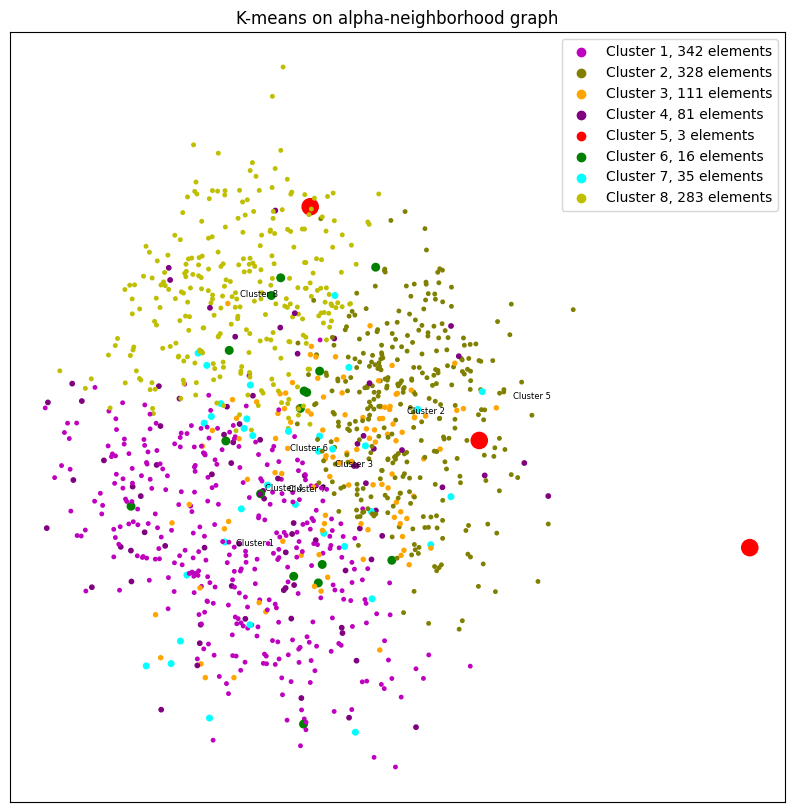

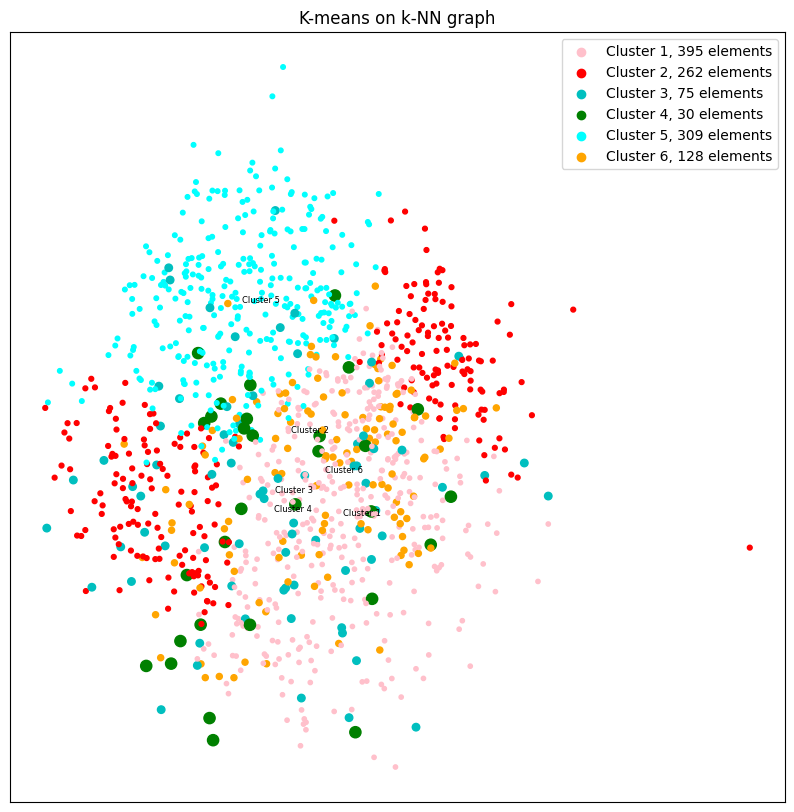

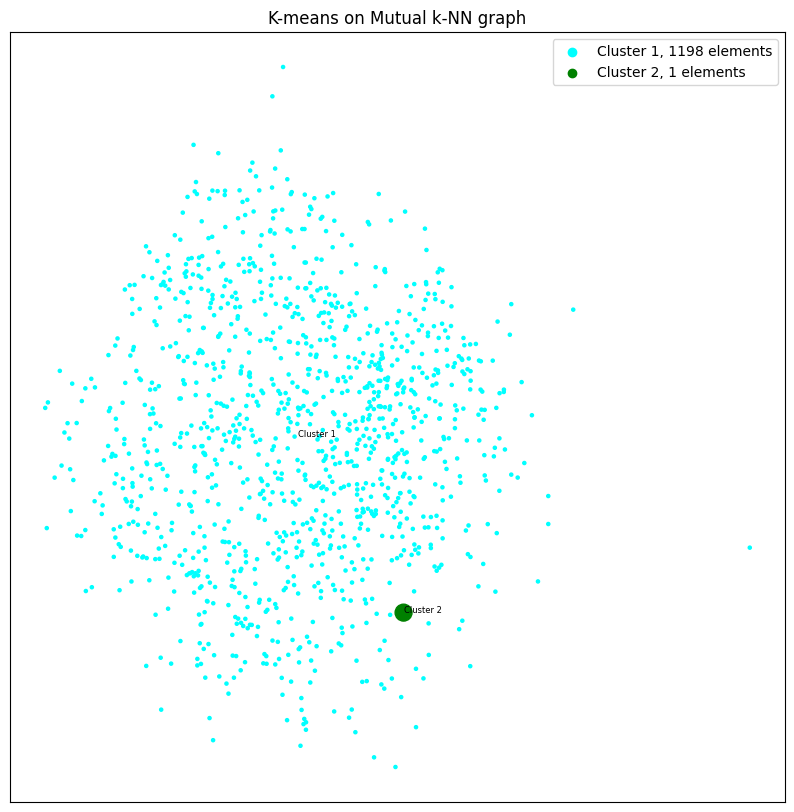

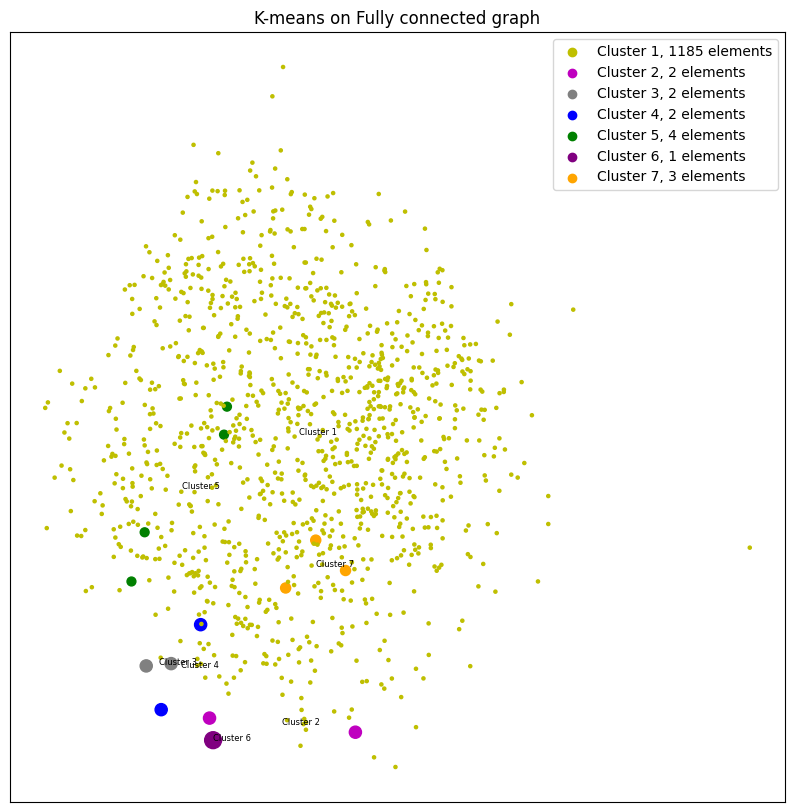

In [24]:
# Clustering using K-means
from sklearn.cluster import KMeans

colors = ['g', 'purple', 'r', 'b', 'orange',
          'pink', 'y', 'm', 'gray', 'c', 'olive', 'cyan']

for i in range(4):
    plt.figure(figsize=(10, 10))
    kmeans = KMeans(n_clusters=norm_best_Ks[i], random_state=0, n_init='auto').fit(
        norm_eigenvectors_list[i][:, :norm_best_Ks[i]])
    labels = kmeans.labels_
    # no of elements in each cluster
    cluster_sizes = np.bincount(labels)
    sizes = np.bincount(labels)
    # print(sizes)

    # size of dot to be inversely proportional to the size of the cluster integer between 1 to 10
    sizes_inv = 1/sizes
    sizes = 5 + 150*sizes_inv/np.max(sizes_inv + 5e-2)
    size_of_pnt = [sizes[labels[i]] for i in range(n)]
    # print(sizes)

    np.random.shuffle(colors)
    c = [colors[(i) % len(colors)] for i in labels]
    plt.scatter(pc[:, 0], pc[:, 1], c=c, s=size_of_pnt,
                alpha=1, edgecolors=c, marker='o')
    plt.title(f'K-means on {plots_titles[i]}')
    plt.xticks([])
    plt.yticks([])
    # add legend to the plot with the size of the cluster
    for i_ in range(len(np.unique(labels))):
        plt.scatter([], [], c=colors[i_],
                    label=f'Cluster {i_+1}, {cluster_sizes[i_]} elements')

    plt.legend()

    K_ = norm_best_Ks[i]
    for k_ in range(K_):
        plt.annotate('Cluster {}'.format(
            k_+1), (pc[labels == k_, 0].mean(), pc[labels == k_, 1].mean()), fontsize=6)

    plt.savefig(f'images/K-means on normalizsed_{plots_titles[i]}.png')
    plt.show()
